Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0397 - val_loss: 0.0202
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0184 - val_loss: 0.0156
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0153 - val_loss: 0.0141
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0140 - val_loss: 0.0136
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0134 - val_loss: 0.0130
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0128 - val_loss: 0.0124
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0123 - val_loss: 0.0119
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0118 - val_loss: 0.0117
Epoch 9/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0114 - val_loss: 0.0113
Epoch 10/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 11/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0108 - val_loss: 0.0108
Epoch 12/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

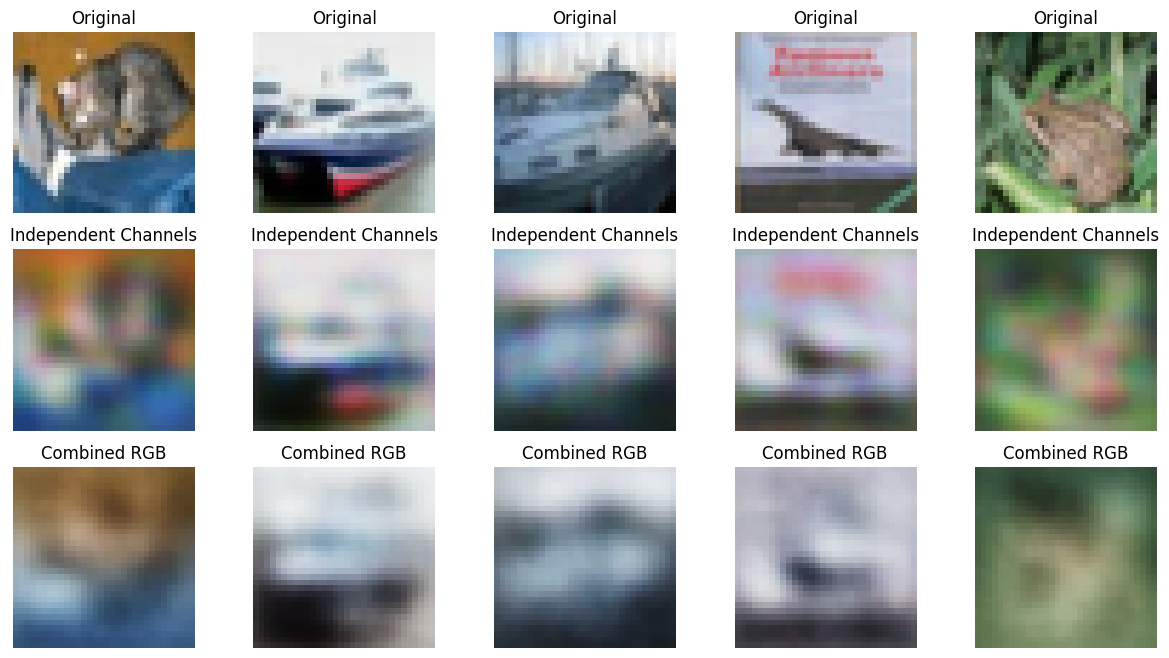

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(x_train, _), (x_test, _) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize

# Separate RGB channels
x_train_r, x_train_g, x_train_b = x_train[..., 0], x_train[..., 1], x_train[..., 2]
x_test_r, x_test_g, x_test_b = x_test[..., 0], x_test[..., 1], x_test[..., 2]


# Define a function to build a simple autoencoder model for a single channel
def build_autoencoder(input_shape):
    input_layer = layers.Input(shape=input_shape)
    encoded = layers.Flatten()(input_layer)
    encoded = layers.Dense(128, activation="relu")(encoded)
    encoded = layers.Dense(64, activation="relu")(encoded)

    decoded = layers.Dense(128, activation="relu")(encoded)
    decoded = layers.Dense(np.prod(input_shape), activation="sigmoid")(decoded)
    decoded = layers.Reshape(input_shape)(decoded)

    return models.Model(input_layer, decoded)


# Instantiate and compile autoencoders for each channel
input_shape = x_train_r.shape[1:]
autoencoder_r = build_autoencoder(input_shape)
autoencoder_g = build_autoencoder(input_shape)
autoencoder_b = build_autoencoder(input_shape)

autoencoder_r.compile(optimizer="adam", loss="mse")
autoencoder_g.compile(optimizer="adam", loss="mse")
autoencoder_b.compile(optimizer="adam", loss="mse")

# Train each autoencoder on its respective channel
autoencoder_r.fit(
    x_train_r,
    x_train_r,
    epochs=20,
    batch_size=128,
    validation_data=(x_test_r, x_test_r),
    verbose=1,
)
autoencoder_g.fit(
    x_train_g,
    x_train_g,
    epochs=20,
    batch_size=128,
    validation_data=(x_test_g, x_test_g),
    verbose=1,
)
autoencoder_b.fit(
    x_train_b,
    x_train_b,
    epochs=20,
    batch_size=128,
    validation_data=(x_test_b, x_test_b),
    verbose=1,
)

# Generate reconstructions for each channel
reconstructed_r = autoencoder_r.predict(x_test_r)
reconstructed_g = autoencoder_g.predict(x_test_g)
reconstructed_b = autoencoder_b.predict(x_test_b)

# Combine RGB channels
reconstructed_independent = np.stack(
    [reconstructed_r, reconstructed_g, reconstructed_b], axis=-1
)

# Build a combined autoencoder for all 3 channels
input_shape_rgb = x_train.shape[1:]
autoencoder_rgb = build_autoencoder(input_shape_rgb)
autoencoder_rgb.compile(optimizer="adam", loss="mse")

# Train the combined RGB autoencoder
autoencoder_rgb.fit(
    x_train,
    x_train,
    epochs=20,
    batch_size=128,
    validation_data=(x_test, x_test),
    verbose=1,
)

# Generate reconstruction from the combined RGB autoencoder
reconstructed_combined = autoencoder_rgb.predict(x_test)

# Visualize results
n = 5  # Number of images to display
plt.figure(figsize=(15, 8))
for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    ax.set_title("Original")
    ax.axis("off")

    # Independent channel reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(reconstructed_independent[i])
    ax.set_title("Independent Channels")
    ax.axis("off")

    # Combined RGB reconstruction
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(reconstructed_combined[i])
    ax.set_title("Combined RGB")
    ax.axis("off")

plt.show()